# Linear Regression

## Application of the Week: Imitation Learning with Dynamical Movement Primitives and Linear Regression

Dynamical Movement Primitives (DMPs) are trajectory representations that

* are goal-directed
* are robust to perturbations and noise (like potential fields)
* are arbitrarily shapeable
* can be scaled and translated arbitrarily, even online
* are parametrized policy representations that can be used for reinforcement learning
* can be used for imitation learning

DMPs consist of superimposed movements:

* a goal-directed movement
* an arbitrarily shapeable "forcing term"
* obstacle avoidance


![Superimposed Movements](files/01_linear_regression/potential_field.svg)

The forcing term can be learned from demonstrations (e.g. from human demonstrations) by linear regression.


![Imitation Learning](files/01_linear_regression/imitation.svg)

In [1]:
# Enable inline plots, import NumPy and Matplotlib
%pylab inline
# Fix seed for random number generator to make the results repeatable
random.seed(0)
# Pretty matrix outputs
numpy.set_printoptions(precision=3, threshold=1000, edgeitems=5, linewidth=80, suppress=True)

Populating the interactive namespace from numpy and matplotlib


## Linear Regression

* We have a training set $T = \{(x^{(n)}, y^{(n)}) | n \in \{1, \ldots, N\}\}$ of


* samples drawn from an **unknown** function $f: \mathbb{R}^D \rightarrow \mathbb{R}$


* with additional Gaussian noise.


* $x^{(n)}$ is an input of the unknown function.


* $y^{(n)}$ is the corresponding desired output (target).


* We want to estimate the mapping.

### Example

Dataset: line + noise

In [2]:
# Training set:
N = 5                                              # Size of the data set
X = np.array([[0.0], [1.0], [2.0], [3.0], [4.0]])  # Inputs, shape: N x 1
y = np.array([10.5, 5.0, 3.0, 2.5, 1.0])           # Outputs, shape: N

print("X =")
print(X)
print("y =")
print(y)

# Test set:
N_test = 100
X_test = linspace(0.0, 4.0, N_test).reshape((N_test, 1))
y_test = linspace(7.0, -5.0, N_test) + 2*random.randn(N_test)

X =
[[ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 4.]]
y =
[ 10.5   5.    3.    2.5   1. ]


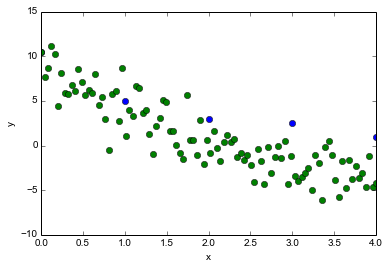

In [3]:
plot(X[:, 0], y, "o")
plot(X_test[:, 0], y_test, "o")
xlabel("x")
ylabel("y")

## Linear Model

* We can write our constraints down with a **linear** model: $$\forall n \in \{1,\ldots,N\}:\quad x^{(n)T} \boldsymbol{w} = y^{(n)} + \epsilon^{(n)},$$ where $\boldsymbol{w}$ is a weight vector and $\epsilon^{(n)} \sim \mathcal{N}(0, \sigma^2)$.


* Weights are parameters of the linear model that can be tuned to fit the training data better.


* A shorter version of this expression is the following equation:
$$\boldsymbol{X} \cdot \boldsymbol{w} = \boldsymbol{y} + \boldsymbol{\epsilon}, \qquad \boldsymbol{X} \in \mathbb{R}^{N \times D}, \boldsymbol{y} \in \mathbb{R}^N, \boldsymbol{\epsilon} \in \mathbb{R}^N, \boldsymbol{w} \in \mathbb{R}^D,$$
where the $n$-th **row** of $\boldsymbol{X}$ represents $x^{(n)}$ and the $n$-th entry of the vector $\boldsymbol{y}$ represents $y^{(n)}$.


* It might not be possible to find a weight vector that satisfies the constraints perfectly. Instead, we can minimize the sum of squared errors (SSE): $$\hat{\boldsymbol{w}} = \text{argmin}_\boldsymbol{w} \dfrac{1}{2}||\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y}||^2_2,$$ where $||\boldsymbol{A}||_2$ is called [Frobenius norm](http://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) and is the generalization of the Euclidean norm for matrices.

## Learning Weights

There are two ways to adjust the weights of a linear model (which includes linear models with nonlinear features):

* **Normal equations** (analytical solution), requires inversion of $D \times D$ matrix, i.e. does not scale well with the number of features
* **Gradient descent** (iterative solution), requires the calculation of $N$ gradients in each step, i.e. does not scale well with the number of examples

In addition, we can add a constraint to the objective function to penalize large weights:

* **Tikhonov regularization**

## Normal Equations

Solving the equation $\boldsymbol{X} \cdot \boldsymbol{w} = \boldsymbol{y}$ directly for $\boldsymbol{w}$ by inversion is not possible, because $\boldsymbol{X}$ is not necessarily a square matrix, i.e. $\boldsymbol{w} = \boldsymbol{X}^{-1} \boldsymbol{y}$ is usually not possible. In addition, it is usually not possible to find an exact solution. Instead, we find the [least squares](http://en.wikipedia.org/wiki/Linear_least_squares_%28mathematics%29) solution, which is the solution of

$$\boldsymbol{X}^T\boldsymbol{X} \hat{\boldsymbol{w}} = \boldsymbol{X}^T\boldsymbol{y}$$

for $\hat{\boldsymbol{w}}$, i.e.

$$\hat{\boldsymbol{w}} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}$$

*Hint:* The expression $(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T$ is equivalent to the [Moore-Penrose pseudoinverse](http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse) $\boldsymbol{X}^+$ of $\boldsymbol{X}$. It is a generalization of the inverse for non-square matrices. You can use this to implement normal equations if your library provides the function. You could also use a least squares solver (e.g. numpy.linalg.lstsq or dgelsd/zgelsd from LAPACK).

[Inversion of 2x2 matrices](https://en.wikipedia.org/wiki/Invertible_matrix#Inversion_of_2.C3.972_matrices):

$$\left(\begin{array}{cc}a & b\\ c & d\end{array}\right)^{-1} = \frac{1}{ad - bc}\left(\begin{array}{cc}d & -b\\ -c & a\end{array}\right)$$

In [4]:
def normal_equations(X, y):
    #w = linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    # ... or we can use the Moore-Penrose pseudoinverse (is usually more likely to be numerically stable)
    #w = linalg.pinv(X).dot(y)
    # ... or we use the solver
    w = linalg.lstsq(X, y)[0]
    return w

# Add bias to each row/instance:
# x11 x12 ...          x11 x12 ... 1
# x21 x22 ...   --->   x21 x22 ... 1
# .                    .
# .                    .
# .                    .
X_bias = hstack((X, ones((N, 1))))
X_test_bias = hstack((X_test, ones((N_test, 1))))
w = normal_equations(X_bias, y)

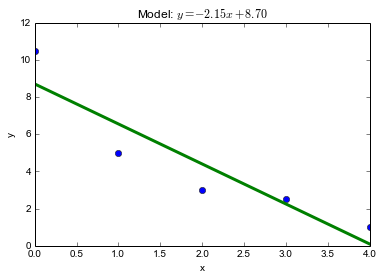

In [5]:
plot(X_bias[:, 0], y, "o")
plot(X_bias[:, 0], X_bias.dot(w), "-", linewidth=3)
xlabel("x")
ylabel("y")
title("Model: $y = %.2f x + %.2f$" % tuple(w))

## Question 1

* inputs: 100 images of size 256x256 pixels
* output: radius of the ball which is at the center of the image
* Is the direct solution via normal equations the fastest solution?

## Answer 1

In [6]:
n_pixels = 256 * 256
memory_size_xtx = n_pixels * n_pixels * 64/8
print("%d GiB" % (memory_size_xtx / 2**30))

32 GiB


Inversion is an operation that requires $O(n^{2.373})$ operations ([Source](http://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations)).

## Gradient Descent

Update $\boldsymbol{w}_t$ incrementally:

$$\boldsymbol{w}_{t+1} = \boldsymbol{w}_t - \alpha \nabla \boldsymbol{w}_t,$$

where

* $\alpha$ is a hyperparameter called "learning rate", it has to be set manually and must usually be within $]0, 1[$, typical values are 10e-1, 10e-2, 10e-3, ...
* $\nabla \boldsymbol{w}_t$ is the **gradient** of $\boldsymbol{w}_t$, i.e. the $i$-th entry of $\Delta \boldsymbol{w}_t$ is the derivative of the error function $E(\boldsymbol{X}, \boldsymbol{y};\boldsymbol{w}_t)$ with respect to the weight $w_i$: $$\Delta {\boldsymbol{w}_t}_i = \frac{\partial E(\boldsymbol{X}, \boldsymbol{y};\boldsymbol{w}_t)}{\partial {w_t}_i}$$

Gradient descent actually is a more general rule that can be applied to any minimization problem if the gradient can be computed (e.g. for artificial neural networks, support vector machines, k-means, ...).

## Gradient of the Linear Model

Error function: sum of squared errors (SSE)
$$E(\boldsymbol{X}, \boldsymbol{y};\boldsymbol{w}) = \frac{1}{2}||\boldsymbol{X} \cdot \boldsymbol{w} - \boldsymbol{y}||^2_2$$

Gradient
$$\nabla \boldsymbol{w} = \nabla_{\boldsymbol{w}} E(\boldsymbol{X}, \boldsymbol{y};\boldsymbol{w}) = \boldsymbol{X}^T \cdot (\boldsymbol{X} \cdot \boldsymbol{w} - \boldsymbol{y})$$

## Question 2

* Why don't we always choose a very small learning rate?
* Your implementation of gradient descent oscillates between two error values. What could be the cause?

## Question 3

* How can we make linear models nonlinear?

## Answer 3

* Nonlinear projection of features (e.g. polynomial regression)
* Kernel trick (e.g. SVR, SVM, ...)
* Mixture of experts (e.g. locally weighted regression, locally weighted projection regression, Gaussian mixture regression, ...)
* Learn nonlinear features (e.g. artificial neural networks)

## Approximation of Nonlinear Functions (with a Linear Model)

To approximate nonlinear funtions with a linear model, we have to generate **nonlinear features**. In this example, we generate **sinusoidal** features. You could also try radial basis functions, polynomials, ...

We expand each feature $x$ to the nonlinear feature vector $(\cos(\frac{0}{d} \pi x), \cos(\frac{1}{d} \pi x), \ldots, \cos(\frac{d}{d} \pi x))^T$, where $d$ is the number of basis functions. Note that $\cos \left(\frac{0}{D} \pi x \right)=1$ is the bias we added manually in the previous example.

In [7]:
def sinusoidalize(X, n_degree):
    X_sinusoidal = numpy.ndarray((len(X), n_degree+1))
    for d in range(n_degree+1):
        X_sinusoidal[:, d] = numpy.cos(X[:, 0] * numpy.pi * d / n_degree)
    return X_sinusoidal

# Utility function
def build_sinusoidal(n_degree, w):
    from itertools import chain
    # That does not look readable but it works :)
    return ((("%+.2f \sin(%d /" + str(n_degree) + " \pi x)") * (n_degree+1)) % tuple(chain(*zip(w, range(n_degree+1)))))

n_degree = 4
X_sinusoidal = sinusoidalize(X, n_degree=n_degree)
X_test_sinusoidal = sinusoidalize(X_test, n_degree=n_degree)
w_sin = normal_equations(X_sinusoidal, y)

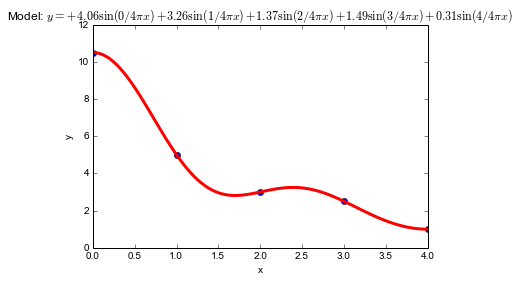

In [8]:
plot(X_bias[:, 0], y, "o")
#plot(X_bias[:, 0], X_bias.dot(w), "-", linewidth=3) # Uncomment to compare with linear approximation
plot(X_test_bias[:, 0], X_test_sinusoidal.dot(w_sin), "-", linewidth=3, color="r")
xlabel("x")
ylabel("y")
title("Model: $y = " + build_sinusoidal(n_degree, w_sin) + "$")

## Question 4

* How can we make a model more general?

## Answer 4

* **Get more training data.**
* Generate artificial training data:
    * Add noise to your training data
    * Example for object recognition: scale, rotate, distort images, select random samples from a bigger image, corrupt image, ...
* Prefer simple models (e.g. degree of polynomial)
* Penalize large weights, for example
    * quadratic values of weights
    * absolute values of weights
    * ...
* Average **different** models (ensemble methods)